In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir = '/content/drive/MyDrive/CSDS 463/Breast_Cancer_Nuclei_Dataset/'

In [3]:
import matplotlib.pyplot as plt
import PIL
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import time
import copy
import albumentations as A
from tqdm import tqdm
import cv2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def preprocess(dir):
  mask_dir = dir + 'Mask/'
  img_dir = dir + 'Original/'
  mask_files = os.listdir(mask_dir)
  img_files = os.listdir(img_dir)

  # Remove images that have no mask
  img_files.remove('10269_00022.tif')

  all_filename = [x.split('_mask')[0] for x in mask_files]
  img_filename = [x + '_original.tif' for x in all_filename]
  mask_filename = [x + '_mask.png' for x in all_filename]

  img_arr = []
  mask_arr = []

  for i in range(len(all_filename)):
    img, mask = PIL.Image.open(img_dir + img_filename[i]), PIL.Image.open(mask_dir + mask_filename[i])
    img, mask = np.array(img), np.array(mask)

    img_arr.append(img)
    mask_arr.append(mask)

  img_arr = np.stack(img_arr,axis=0)
  mask_arr = np.stack(mask_arr,axis=0)


  np.save(dir + 'All.npy',{'image':img_arr,'mask':mask_arr})

In [5]:
def visualize(images,masks):
  n = images.shape[0]
  idx = np.random.choice(n,1)[0]

  img = images[idx]
  mask = masks[idx]

  fig, axs = plt.subplots(1,3,figsize=(10,10))
  axs[0].set_title('Original image')
  axs[0].imshow(img)

  axs[1].set_title('Mask')
  axs[1].imshow(mask)

  axs[2].set_title('Masked Image')
  axs[2].imshow(img)
  axs[2].imshow(mask,alpha=0.5)

In [6]:
data = np.load(dir + 'All.npy',allow_pickle=True)

images = data.item()['image']
masks = data.item()['mask']

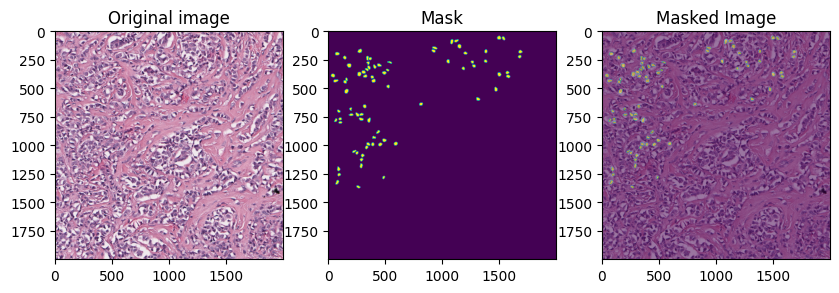

In [7]:
visualize(images,masks)

In [8]:
class NucleiDataset(torch.utils.data.Dataset):
  def __init__(self,images,masks,transform = None):
    assert images.shape[0] == masks.shape[0], "Images and Masks have to be same size"

    self.n = images.shape[0]
    self.images = images
    self.masks = masks
    self.transform = transform


  def __len__(self):
    return self.n

  def __getitem__(self,idx):
    curr_image = self.images[idx]
    curr_mask = self.masks[idx]

    if self.transform:
      curr_image =  cv2.normalize(curr_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
      curr_image = self.transform(curr_image) # (C,H,W)
      curr_mask = self.transform(curr_mask).squeeze()


    return [curr_image, curr_mask]


In [9]:
def image_patch(image,mask,group=2,discard=True):
    H,W,C = image.shape
    qH , qW = H // 2**(group-1), W // 2**(group-1)

    img_list = []
    mask_list = []

    for i in range(2**(group-1)):
        for j in range(2**(group-1)):
            qH_s, qH_e ,qW_s, qW_e = qH*i, qH*(i+1), qW*j, qW * (j+1)
            cur_image = image[qH_s:qH_e, qW_s:qW_e,:]
            cur_mask = mask[qH_s:qH_e, qW_s:qW_e]

            # Discard image with no mask
            if discard and not np.any(cur_mask):
              continue

            img_list.append(cur_image)
            mask_list.append(cur_mask)

    if len(img_list) == 0:
       return None, None

    return np.stack(img_list,axis=0), np.stack(mask_list,axis=0)

In [10]:
group = 4

img_patch_list = []
mask_patch_list = []
for img,mask in zip(images,masks):
  patch_image,patch_mask = image_patch(img,mask,group=group,discard=True)

  if patch_image is not None:
    img_patch_list.append(patch_image)
    mask_patch_list.append(patch_mask)

patch_images = np.concatenate(img_patch_list,axis=0)
patch_masks = np.concatenate(mask_patch_list,axis=0)

In [11]:
print(patch_images.shape,patch_masks.shape)

(3928, 250, 250, 3) (3928, 250, 250)


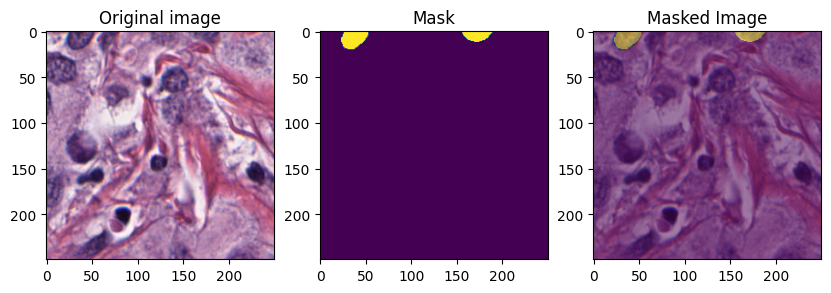

In [12]:
visualize(patch_images,patch_masks)

In [13]:
# num_samples = images.shape[0]
num_samples = patch_images.shape[0]
split_ratio = 0.8
batch_size = 16
train_size = int(num_samples * split_ratio)
H_resize, W_resize = 256, 256

In [14]:
# A_transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

In [15]:
# Resize Interpolation affect accuracy
transform = torchvision.transforms.Compose([
    T.ToTensor(),
    T.Resize((H_resize,W_resize),interpolation=T.InterpolationMode.NEAREST_EXACT)
])

train_dataset = NucleiDataset(patch_images[:train_size],patch_masks[:train_size],transform)
test_dataset = NucleiDataset(patch_images[train_size:],patch_masks[train_size:],transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

print(len(train_dataset),len(test_dataset))
print(test_dataset[0][0].shape,test_dataset[0][1].shape)

3142 786
torch.Size([3, 256, 256]) torch.Size([256, 256])


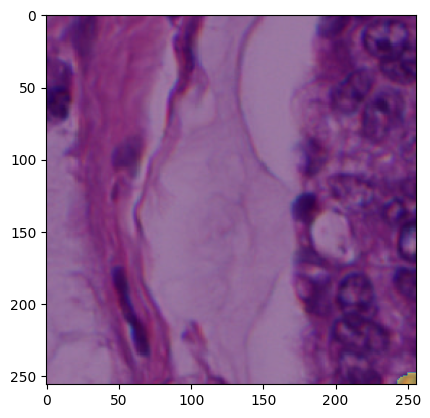

In [16]:
img , mask = train_dataset[3]
plt.imshow(img.permute(1,2,0))
plt.imshow(mask,alpha=0.5)

In [17]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        out = self.sigmoid(out)


        return out.squeeze()

In [18]:
def dice_loss(predict, target, smooth = 1.):

    dice_score = dice_coef(predict, target, smooth)

    return 1 - dice_score


def dice_coef(predict, target , smooth = 1.):
    predict = predict.contiguous().view(predict.shape[0], -1)
    target = target.contiguous().view(target.shape[0],-1)


    intersection = torch.sum(predict * target, dim=1)
    union = torch.sum(predict.pow(2), dim=1) + torch.sum(target.pow(2), dim=1)

    score = (2 * intersection + smooth) / (union + smooth)


    return  torch.mean(score)


In [19]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy(pred,target)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def output_metrics(metrics, epoch_samples, phase, history):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        history[phase][k].append(metrics[k]/epoch_samples)

    print("{}: {}".format(phase, ", ".join(outputs)))


In [20]:
def train_model(model, optimizer, scheduler, dataloaders, num_epochs=25, bce_weight=0.5):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    history = {'train':{'bce':[],'dice':[],'loss':[]},'val':{'bce':[],'dice':[],'loss':[]}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float().squeeze()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, bce_weight)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            output_metrics(metrics, epoch_samples, phase, history)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(),dir + 'best_weight.pth')
    return model, history

In [21]:
LOAD_CKPT = False
TRAIN = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_class = 1
model = UNet(num_class).to(device)

if LOAD_CKPT:
    checkpoint = dir + 'checkpoint/best_weight_3group.pth'

    ckpt = torch.load(checkpoint,map_location=device)
    model.load_state_dict(ckpt)


if TRAIN:
    dataloaders = {'train':train_dataloader,'val':test_dataloader}

    optimizer_ft = torch.optim.Adam(model.parameters(), lr=5e-4)

    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.8)

    model,history = train_model(model, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=100, bce_weight=0.5)

Epoch 0/99
----------
LR 0.0005


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train: bce: 0.184892, dice: 0.718317, loss: 0.451604
val: bce: 0.209997, dice: 0.670202, loss: 0.440100
saving best model
0m 21s
Epoch 1/99
----------
LR 0.0005
train: bce: 0.166878, dice: 0.687670, loss: 0.427274
val: bce: 0.149881, dice: 0.673956, loss: 0.411919
saving best model
0m 21s
Epoch 2/99
----------
LR 0.0005
train: bce: 0.151739, dice: 0.631571, loss: 0.391655
val: bce: 0.150530, dice: 0.581022, loss: 0.365776
saving best model
0m 21s
Epoch 3/99
----------
LR 0.0005
train: bce: 0.134691, dice: 0.567551, loss: 0.351121
val: bce: 0.164877, dice: 0.562693, loss: 0.363785
saving best model
0m 21s
Epoch 4/99
----------
LR 0.0005
train: bce: 0.125771, dice: 0.534328, loss: 0.330049
val: bce: 0.134782, dice: 0.544099, loss: 0.339440
saving best model
0m 21s
Epoch 5/99
----------
LR 0.0005
train: bce: 0.119213, dice: 0.508122, loss: 0.313668
val: bce: 0.138260, dice: 0.536516, loss: 0.337388
saving best model
0m 21s
Epoch 6/99
----------
LR 0.0005
train: bce: 0.115615, dice: 0.4906

In [22]:
def iou(predict,target):
    predict = predict.view(-1)
    target = target.view(-1)

    intersection = torch.logical_and(predict, target).sum()
    union = torch.logical_or(predict, target).sum()

    iou_score = intersection / union

    return iou_score

In [23]:
def recover_from_patch(patch_image,group):
    group_num = 2**(group-1)
    sv = []
    for i in range(group_num):
        sh = []
        for j in range(group_num):
            sh.append(patch_image[i*group_num + j])
        sv.append(np.hstack(sh))
    recover_image = np.vstack(sv)

    return recover_image


def visualize_prediction(model, images, threshold=0.05,group=3,save=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    idx = np.random.choice(images.shape[0],1)[0]
    original_image,original_mask = images[idx], masks[idx]

    patch_image, patch_mask = image_patch(original_image,original_mask,group=group,discard=False)

    trans_image_list = []
    trans_mask_list = []
    for img,mask in zip(patch_image,patch_mask):
      trans_image_list.append(transform(img))
      trans_mask_list.append(transform(mask))

    trans_image = np.stack(trans_image_list,axis=0)
    trans_mask = np.stack(trans_mask_list,axis=0)


    model.eval()
    prediction = model(torch.from_numpy(trans_image).to(device).float()).detach().cpu()

    recover_prediction = recover_from_patch(prediction,group)

    resize_fn = T.Resize((2000,2000),T.InterpolationMode.NEAREST)
    recover_prediction = resize_fn(torch.from_numpy(recover_prediction).unsqueeze(0)).squeeze().numpy()

    fig,axs = plt.subplots(1,3,figsize=(15,15))

    axs[0].imshow(original_image)
    axs[0].imshow(recover_prediction >= threshold,alpha=0.7)
    axs[0].set_title(f"Prediction with threshold:{threshold}")
    axs[1].imshow(original_mask)
    axs[1].set_title(f"Ground Truth Label")
    axs[2].imshow(original_image)
    axs[2].set_title("Image")

    if save:
      fig.savefig(f"Prediction_Result_{threshold}.png",bbox_inches='tight',)

    plt.show()

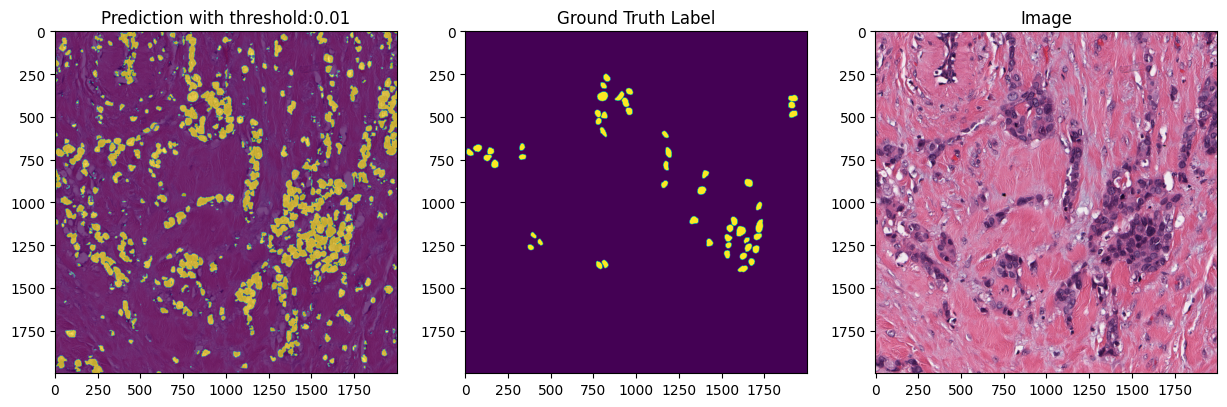

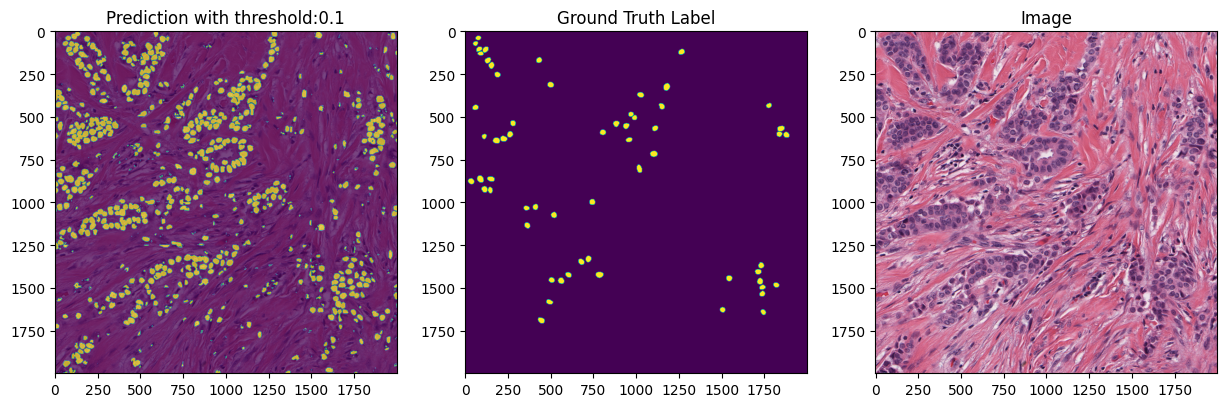

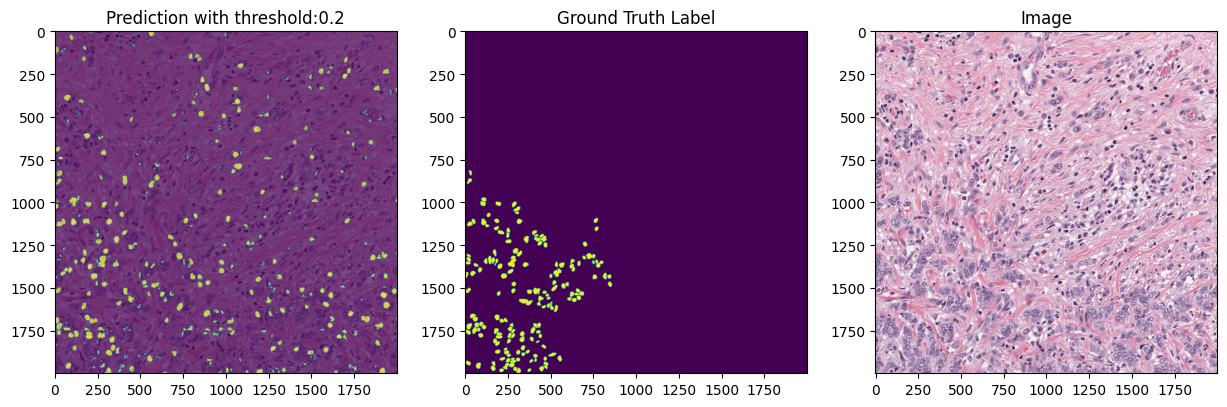

In [24]:
visualize_prediction(model,images,threshold=0.01,group=group,save=False)
visualize_prediction(model,images,threshold=0.1,group=group,save=False)
visualize_prediction(model,images,threshold=0.2,group=group,save=False)

In [25]:
def evaluate_model(model,test_dataloader,threshold):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    total_num = 0
    total_dice = 0
    total_iou = 0

    model.eval()
    for image , mask in test_dataloader:

        image = image.to(device).float()
        mask = mask.to(device).float().squeeze()
        pred = model(image)


        pred = pred >= threshold

        total_dice += dice_coef(pred,mask,smooth=0.1).item() * image.size(0)
        total_iou += iou(pred,mask).item() * image.size(0)

        total_num += image.size(0)

        del image
        del mask
        del pred

        torch.cuda.empty_cache()

    dice_score = total_dice / total_num
    iou_score = total_iou / total_num

    return dice_score, iou_score



In [ ]:
evaluate = True

if evaluate:
  threshold = np.arange(0.000,1+0.005,0.005)

  dl, il = [], []
  for t in tqdm(threshold):
      dice_s, iou_s = evaluate_model(model,test_dataloader, threshold=t)
      dl.append(dice_s)
      il.append(iou_s)

  fig,axs = plt.subplots(1,2,figsize=(15,8))

  scale_fn = lambda x: x * 100

  axs[0].plot(threshold,list(map(scale_fn,dl)))
  axs[1].plot(threshold,list(map(scale_fn,il)))

  fig.savefig('Group_3_Score.png',bbox_inches='tight')
  print(max(dl),max(il))
  print(threshold[np.argmax(dl)], threshold[np.argmax(il)])

 15%|█▌        | 31/201 [03:24<18:51,  6.66s/it]

In [ ]:
visualize_prediction(model,images,threshold=threshold[np.argmax(dl)],group=group)
visualize_prediction(model,images,threshold=threshold[np.argmax(il)],group=group)